In [46]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

### theory data

In [127]:
THEORY_POWERS = [10, 50, 100]
THEORY_DELAYS = [10, 30, 50, 70, 90, 110]
THEORY_INTEGRATING_DELAYS = [25, 40, 75]

THEORY_XLIM = [0.5, 3.0]

def load_theory_result(power, delays=THEORY_DELAYS):

    dirmap = {
        10: "fig4a",
        50: "fig4b",
        100: "fig4c",
    }

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"{dirmap[power]}/rdp47_{power:03d}_{delay:03d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def load_theory_integrating(power, delays=THEORY_INTEGRATING_DELAYS):

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"fig5/rdp30_cal_{power:03d}_{delay:02d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def normalize(radial_profile, rng=(50, 340)):
    div = radial_profile[...,rng[0]:rng[1]].sum(-1)[...,None]
    return radial_profile / ( div + 1e-16)

### integrated pulses (original fig 5)

In [108]:
integrating_10power = load_theory_integrating(10)
integrating_100power = load_theory_integrating(100)

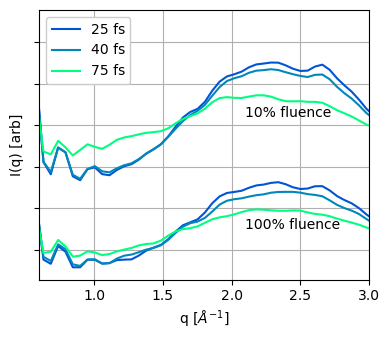

In [151]:
plt.figure(figsize=(4,3.5))

ax = plt.subplot(111)

for i,b in enumerate(THEORY_INTEGRATING_DELAYS):
    plt.plot(integrating_10power[:,0], integrating_10power[:,i+1] + 2e4, color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()))
    plt.plot(integrating_100power[:,0], integrating_100power[:,i+1], color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()), label="_nolegend_")

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.grid()
ax.set_xlim([0.6,3.0])
ax.set_yticklabels([])

plt.legend(
    ['%d fs' % b for b in THEORY_INTEGRATING_DELAYS], 
    prop={'size': 10},
    ncol=1,
    framealpha=1.0,
    loc=2
)

ax.text(2.1, 4.2e4, f"10% fluence")
ax.text(2.1, 1.5e4, f"100% fluence")

plt.tight_layout()
plt.savefig("./integrated_pulse_simulation.png")
plt.show()

### experimental vs simulation (original figs 1 + 4)

In [5]:
experimental_data = np.loadtxt("../csvs/water_Iq_v_time.csv", delimiter=',')
print(experimental_data.shape)
EXPERIMENTAL_DELAYS = np.array([10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0])

(500, 12)


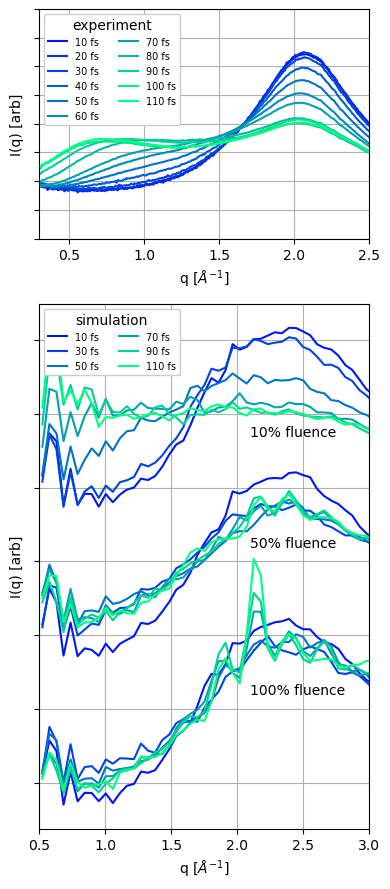

In [150]:
# RP vs Delay Time

# --- peak positions to monitor later (in array idx)
new_peak_pos = 90
wat_peak_pos = 280
XLIM = [0.3, 2.5]
GRID = True
NORMALIZE = True

# --- plotting
fig = plt.figure(figsize=(4,3*3))
gs = gridspec.GridSpec(3, 1)

ax = fig.add_subplot(gs[0])

for i,b in enumerate(EXPERIMENTAL_DELAYS):
    ax.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()))

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(XLIM)
ax.set_ylim([0.0, 0.008])
ax.set_yticklabels([])
if GRID: ax.grid()

plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=2,
    framealpha=1.0,
    title="experiment"
)

# ----------

ax = fig.add_subplot(gs[1:])

for ax_i, theory_power in enumerate(THEORY_POWERS):

    theoretical_data = load_theory_result(theory_power)

    for i,b in enumerate(THEORY_DELAYS):

        offset = 0.02

        if NORMALIZE:
            y = normalize(theoretical_data[:,i+1], rng=[0, -1])
        else:
            y = theoretical_data[:,i+1]

        ax.plot(
            theoretical_data[:,0], y - ax_i * offset,
            color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
        )

ax.text(2.1,  0.017, f"10% fluence")
ax.text(2.1,  0.002, f"50% fluence")
ax.text(2.1, -0.018, f"100% fluence")

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(THEORY_XLIM)
#ax.set_xlim(XLIM)
ax.set_yticklabels([])
if GRID: ax.grid()

plt.legend(
    ['%d fs' % b for b in THEORY_DELAYS], 
    prop={'size': 7},
    ncol=2,
    framealpha=1.0,
    loc=2,
    title=f"simulation"
)

plt.tight_layout()
plt.savefig("./combined_normalized_same-qaxis.png")
plt.show()

### oxygen ionization states (original figure 2)

- ion*: average ionization degree of oxygen
- first column: time[fs], 0fs = center of the pump pulse
- second column: average ionization degree [-]

- csp*: charge state population
- first column: time[fs], 0fs = center of the pump pulse
- columns 2 and higher give relative populations (0 to 1) of ionization stages of oxygen (neutral,1+,..)

note: figures do not show all columns that are included in data files.

In [152]:
csp_010 = np.genfromtxt("./fig2/csp47_010_single.txt")
csp_100 = np.genfromtxt("./fig2/csp47_100_double.txt")

ion_010 = np.genfromtxt("./fig2/ion47_010_single.txt")
ion_100 = np.genfromtxt("./fig2/ion47_100_double.txt")

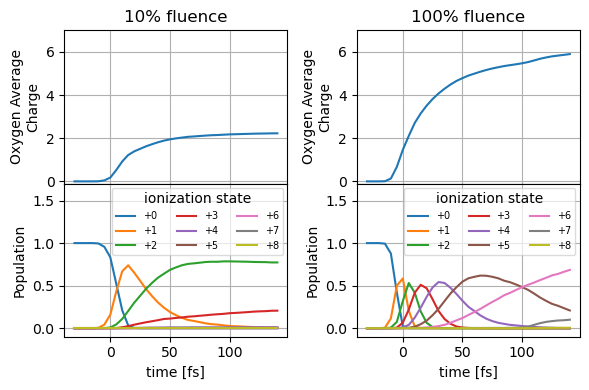

In [208]:
fix, axes = plt.subplots(2, 2, sharex=True, figsize=(6,4))

axes[0,0].plot(ion_010[:,0], ion_010[:,1])
axes[0,1].plot(ion_100[:,0], ion_100[:,1])

axes[0,0].set_title("10% fluence")
axes[0,1].set_title("100% fluence")

for i in range(2):
    axes[0,i].set_ylim([-0.1, 7.0])
    axes[0,i].set_ylabel("Oxygen Average\nCharge")
    axes[0,i].grid()

# --------

axes[1,0].plot(csp_010[:,0], csp_010[:,1:])
axes[1,1].plot(csp_100[:,0], csp_100[:,1:])

for i in range(2):
    axes[1,i].set_ylim([-0.1, 1.7])
    axes[1,i].set_ylabel("Population")
    axes[1,i].grid()

    axes[1,i].legend(
        [f"+{i}" for i in range(9)],
        loc=1, 
        ncol=3,
        prop={'size': 7},
        framealpha=0.7,
        title="ionization state",
    )

# --------

for i in range(2):
    axes[1,i].set_xlabel('time [fs]')

# --------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("ionization_states.png")
plt.show()

### form factor vs structure factor contribution (original figure 3)

In [233]:
def load_factor_block(fluence):

    data = [
        np.genfromtxt("./fig3/rdp47_undam_water.txt")[:,0] / 1e10,
        np.genfromtxt("./fig3/rdp47_undam_water.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_disponly.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_formfonly.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_fulldam.txt")[:,1],
    ]

    return np.vstack(data).T

factor_block_010 = load_factor_block("010")
factor_block_100 = load_factor_block("100")

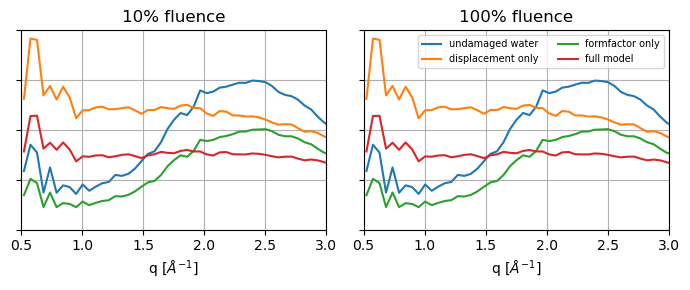

In [250]:
plt.figure(figsize=(7,3))

for ib, block in enumerate([factor_block_010, factor_block_100]):

    ax = plt.subplot(1, 2, ib+1)

    for i in range(4):
        plt.plot(factor_block_010[:,0], factor_block_010[:,i+1])

    ax.set_yticklabels([])
    ax.set_xlabel('q [$\AA^{-1}]$')
    ax.set_xlim(THEORY_XLIM)
    ax.set_ylim([0,2e5])
    ax.grid()

    if ib == 0:
        ax.set_title("10% fluence")
    elif ib == 1:
        ax.set_title("100% fluence")

plt.legend(
    [
        "undamaged water",
        "displacement only",
        "formfactor only",
        "full model"
    ],
    loc=1,
    ncol=2,
    prop={'size': 7},
)

plt.tight_layout()
plt.savefig("./formfactor_vs_structurefactor.png")
plt.show()